# Análise do jogo político utilizando [Dados Abertos](http://dadosabertos.camara.leg.br)

![dados abertos](images/dados-abertos.png)

## Objetivos

### => Extrair informações de votações da API de Dados Abertos utilizando a linguagem Python
### => Preparar os dados para análise com a biblioteca Pandas
### => Visualizar o posicionamento político utilizando algoritmos de redução de dimensionalidade
### => Aplicar aprendizado não supervisionado para analizar a coesão partidária
### => Identificar aplicações potenciais dos dados de votação da API de Dados Abertos
<br/><br/>

## Problema: Como entender objetivamente a dinâmica política?
![plenario](images/motivacao1.jpg)
![plenario](images/motivacao2.png)
![plenario](images/motivacao3.png)

### Estudo de referência: [Data Mining in Politics](http://www.stat.columbia.edu/~jakulin/Politics/) (EUA)

![Data Mining in Politics](images/politics-votes-us.png)

### Vantagens da análise por parlamentar
* Maior riqueza de informações
* Possibilita análise de apenas uma proposição
* Independe do número de partidos (permite comparar com os EUA, por exemplo)
* Responde à questão: Quantos e quais são os "reais" partidos?
* Permite analisar a coesão partidária

## Extração de informações de proposições da API de Dados Abertos

### O que é uma proposição?

Segundo o Art. 100 do Regimento Interno da Câmara dos Deputados:
![proposicao](images/proposicao.png)

### Entidades envolvidas

![entidades](images/entidades.png)

### Implementação das classes

In [46]:
import pandas as pd

class Votante:
    
    def __init__(self):
        self.votos = {}
        
    def add_voto(self, voto, id_votacao):
        
        if self.votos is None:
            self.votos = {}
        
        self.votos[id_votacao] = voto
    
    def __repr__(self):
        return '%s - %s' % (self.id, self.votos)
    
    
class Deputado(Votante):
    
    def __init__(self, json_data=None, xml_data=None):
        super(Deputado, self).__init__()
        
        if xml_data:
            self.parse_xml(xml_data)
        elif json_data:
            self.parse_json(json_data)
            
    def parse_json(self, data):        
        self.id = data['id']
        self.nome = data['nome']
        self.partido = data['siglaPartido']
        self.uf = data['siglaUf']
        
    def parse_xml(self, data):
        raise NotImplementedError('XML format not supported')
    
    def __repr__(self):
        return "%s - %s - %s" % (self.nome, self.partido, self.votos)
    
    
class Bancada(Votante):
    
    def __init__(self, id):
        super(Bancada, self).__init__()
        self.id = id
        
    def __repr__(self):
        return "Bancada_%s - %s" % (self.id, self.votos)

    
class Votacao:
    
    def __init__(self, json_data=None, xml_data=None):
        
        if xml_data:
            self.parse_xml(xml_data)
        elif json_data:
            self.parse_json(json_data)
   
    def parse_json(self, data):        
        self.id = data['id']
        self.titulo = data['titulo']
        self.tipo = data['tipoVotacao']
        
    def parse_xml(self, data):
        raise NotImplementedError('XML format not supported')
        
    def __repr__(self):
        return '%s - %s (id: %s)' % (self.tipo, self.titulo, self.id)

    
class Proposicao:
    
    def __init__(self, json_data=None, xml_data=None):
        
        self.votantes = {}
        self.votacoes = {}
        
        if xml_data:
            self.parse_xml(xml_data)
        elif json_data:
            self.parse_json(json_data)
    
    def add_votante(self, votante):
    
        if votante.id in self.votantes:
            self.votantes[votante.id].votos.update(votante.votos)
        else:
            self.votantes[votante.id] = votante        
    
    def parse_json(self, data):        
        prop = data[0]
        self.id = prop['id']
        self.sigla = prop['siglaTipo']
        self.numero = prop['numero']
        self.ano = prop['ano']
    
    def parse_xml(self, data):
        raise NotImplementedError('XML format not supported')
                            
    def to_dataframe(self):
        
        votos = pd.DataFrame()

        for i, votante in self.votantes.items():

            if isinstance(votante, Deputado):
                row = {'nome': votante.nome, 'partido': votante.partido, 'uf': votante.uf}
            else:
                row = {'nome': 'Bancada_' + votante.id, 'partido': votante.id, 'uf': 'BR'}
            
            for j, votacao in proposicao.votacoes.items():
                key = votacao.titulo + '-' + str(votacao.id)
                row[key] = votante.votos.get(votacao.id)

            votos = votos.append(row, ignore_index=True)
                
        return votos
    
    def __repr__(self):
        return '%s - %s/%s (%d votações; %d votantes; id: %d)' % (self.sigla, self.numero, self.ano, 
                                                          len(self.votacoes), len(self.votantes), self.id)

### Consultando web service do Dados Abertos

In [28]:
import urllib.request as req
import json

DOMAIN = 'dadosabertos.camara.leg.br'

def get_url_proposicao(tipo, numero, ano):
    #url = 'http://www.camara.leg.br/SitCamaraWS/Proposicoes.asmx/ObterVotacaoProposicao?tipo=%s&numero=%s&ano=%s'
    url = 'https://%s/api/v2/proposicoes?siglaTipo=%s&numero=%s&ano=%s&ordem=ASC&ordenarPor=id'
    return url % (DOMAIN, tipo, numero, ano)

def get_url_votacao_detalhes(id_votacao):
    url = 'https://%s/api/v2/votacoes/%s'
    return url % (DOMAIN, id_votacao)

def get_url_votacoes(id_proposicao):
    url = 'https://%s/api/v2/proposicoes/%s/votacoes'
    return url % (DOMAIN, id_proposicao)

def get_url_votos(id_votacao, page=1, items=100):
    url = 'https://%s/api/v2/votacoes/%s/votos?pagina=%s&itens=%s'
    return url % (DOMAIN, id_votacao, page, items)

def get_resource(url):   
    file = req.urlopen(url)
    return file

def get_votantes(id_votacao, page=1, verbose=True):
    
    if verbose:
        print('Buscando votantes (id votação: {}) ...'.format(id_votacao))
    
    url = get_url_votos(id_votacao, page=page)
    file = get_resource(url)
    data = json.loads(file.read())
    
    votantes = []
    
    for v in data['dados']:
        deputado = Deputado(v['parlamentar'])
        deputado.add_voto(v['voto'], id_votacao)
        votantes.append(deputado)
    return votantes

def get_bancadas(id_votacao, verbose=True):
    
    if verbose:
        print('Buscando orientações de bancada (id votação: {}) ...'.format(id_votacao))
        
    url = get_url_votacao_detalhes(id_votacao)
    file = get_resource(url)
    data = json.loads(file.read())
    
    bancadas = []
    
    for v in data['votacoes_']['orientacoes']:
        bancada = Bancada(v['nomeBancada'])
        bancada.add_voto(v['voto'], id_votacao)
        bancadas.append(bancada)
    return bancadas

def get_votacoes(id_proposicao, verbose=True):
    
    if verbose:
        print('Buscando votações (id proposição: {}) ...'.format(id_proposicao))
    
    url = get_url_votacoes(id_proposicao)
    file = get_resource(url)
    data = json.loads(file.read())
    return [Votacao(v) for v in data['dados']]

def get_proposicao(tipo, numero, ano, verbose=True):    
    
    if verbose:
        print('Buscando proposição: {} {}/{} ...'.format(tipo, numero, ano))
        
    url = get_url_proposicao(tipo, numero, ano)
    file = get_resource(url)
    data = json.loads(file.read())
    
    if len(data['dados']) == 0:
        print('Proposição não encontrada: {} {}/{}'.format(tipo, numero, ano))
        return
    
    proposicao = Proposicao(data['dados'])
    # busca votações relacionadas
    votacoes = get_votacoes(proposicao.id, verbose)
    
    for votacao in votacoes:
        proposicao.votacoes[votacao.id] = votacao
        
        # busca votantes
        for p in range(1,6):
            votantes = get_votantes(votacao.id, page=p, verbose=verbose)
            for votante in votantes:
                proposicao.add_votante(votante)
        
        # busca orientações de bancada
        bancadas = get_bancadas(votacao.id, verbose)
            
        for bancada in bancadas:
            proposicao.add_votante(bancada)
            
    return proposicao

### Estudo de caso: [Projeto de Lei 6787 de 2016](http://www.camara.gov.br/proposicoesWeb/fichadetramitacao?idProposicao=2122076)

In [3]:
#get_url_proposicao('PL', 6787, 2016)
get_url_proposicao('PEC', 171, 1993)

'https://dadosabertos-hom.camara.leg.br/api/v2/proposicoes?siglaTipo=PEC&numero=171&ano=1993&ordem=ASC&ordenarPor=id'

In [35]:
votantes = get_votantes(7485)
print(len(votantes))

Buscando votantes (id votação: 7485) ...
100


In [47]:
proposicao = get_proposicao('PL', 6787, 2016)
#proposicao = get_proposicao('PEC', 171, 1993)
proposicao

Buscando proposição: PL 6787/2016 ...
Buscando votações (id proposição: 2122076) ...
Buscando votantes (id votação: 7484) ...
Buscando votantes (id votação: 7484) ...
Buscando votantes (id votação: 7484) ...
Buscando votantes (id votação: 7484) ...
Buscando votantes (id votação: 7484) ...
Buscando orientações de bancada (id votação: 7484) ...
Buscando votantes (id votação: 7483) ...
Buscando votantes (id votação: 7483) ...
Buscando votantes (id votação: 7483) ...
Buscando votantes (id votação: 7483) ...
Buscando votantes (id votação: 7483) ...
Buscando orientações de bancada (id votação: 7483) ...
Buscando votantes (id votação: 7492) ...
Buscando votantes (id votação: 7492) ...
Buscando votantes (id votação: 7492) ...
Buscando votantes (id votação: 7492) ...
Buscando votantes (id votação: 7492) ...
Buscando orientações de bancada (id votação: 7492) ...
Buscando votantes (id votação: 7494) ...
Buscando votantes (id votação: 7494) ...
Buscando votantes (id votação: 7494) ...
Buscando vot

PL - 6787/2016 (9 votações; 506 votantes; id: 2122076)

### Votações relacionadas

In [39]:
for v in proposicao.votacoes:
    print(proposicao.votacoes[v])

Nominal Eletrônica - REQUERIMENTO DE RETIRADA DE PAUTA (id: 7484)
Nominal Eletrônica - REQUERIMENTO DE VOTAÇÃO NOMINAL DO REQ. DE RETIRADA DE PAUTA (id: 7483)
Nominal Eletrônica - SUBEMENDA SUBSTITUTIVA GLOBAL (id: 7492)
Nominal Eletrônica - DTQ 2  - PDT - ART. 442-B, CONST. DO ART. 1º DO SUBSTITUTIVO (id: 7494)
Nominal Eletrônica - REQUERIMENTO DE ENCERRAMENTO DA DISCUSSÃO E DO ENCAMINHAMENTO (id: 7486)
Nominal Eletrônica - DTQ 18 - PSOL- ART. 611-A, CONST.  DO ART. 1º DO SUBSTITUTIVO (id: 7498)
Nominal Eletrônica - REQUERIMENTO DE RETIRADA DE PAUTA (id: 7485)
Nominal Eletrônica - DTQ 54 - PT - EMENDA DE PLENÁRIO Nº 15 (id: 7503)
Nominal Eletrônica - DTQ 51 - SD - EMENDA DE PLENÁRIO Nº 28 (id: 7504)


## Preparação dos dados
O primeiro passo é transformar os dados em um dataframe da biblioteca ```pandas```.

In [48]:
votos = proposicao.to_dataframe()
print(votos.shape)
votos.head()

(506, 12)


,"DTQ 18 - PSOL- ART. 611-A, CONST. DO ART. 1º DO SUBSTITUTIVO-7498","DTQ 2 - PDT - ART. 442-B, CONST. DO ART. 1º DO SUBSTITUTIVO-7494",DTQ 51 - SD - EMENDA DE PLENÁRIO Nº 28-7504,DTQ 54 - PT - EMENDA DE PLENÁRIO Nº 15-7503,REQUERIMENTO DE ENCERRAMENTO DA DISCUSSÃO E DO ENCAMINHAMENTO-7486,REQUERIMENTO DE RETIRADA DE PAUTA-7484,REQUERIMENTO DE RETIRADA DE PAUTA-7485,REQUERIMENTO DE VOTAÇÃO NOMINAL DO REQ. DE RETIRADA DE PAUTA-7483,SUBEMENDA SUBSTITUTIVA GLOBAL-7492,nome,partido,uf
0,Sim,Sim,Não,Não,Sim,Não,Não,None,Sim,ABEL MESQUITA JR.,DEM,RR
1,Sim,Sim,Não,Não,Sim,Não,Não,Não,Sim,ADALBERTO CAVALCANTI,PTB,PE
2,Não,Não,Sim,Sim,Não,Obstrução,Obstrução,Obstrução,Não,ADELMO CARNEIRO LEÃO,PT,MG
3,Sim,Sim,Não,Não,Sim,Não,Não,Não,Sim,ADÉRMIS MARINI,PSDB,SP
4,Sim,Sim,None,Não,None,Não,Não,Não,Sim,AELTON FREITAS,PR,MG


### O "vetor político"
Cada sequência de votos forma um vetor de posicionamento político em relação ao conjunto de proposições.

In [49]:
import numpy as np
np.random.seed(23)
# criando um vetor político aleatório
vetor_politico = np.random.choice(['Sim', 'Não', 'Obstrução'], size=votos.shape[1]-3, p=[2/5, 2/5, 1/5])
vetor_politico

array(['Não', 'Obstrução', 'Não', 'Sim', 'Sim', 'Não', 'Sim', 'Sim', 'Não'], 
      dtype='<U9')

Vamos adicionar um novo votante no conjunto de dados para comparar o seus posicionamento com os outros votantes.

In [50]:
row = {'nome': 'Campuseiro', 'partido': 'Campus Party', 'uf': 'DF'}

for i, key in enumerate(proposicao.votacoes):
    row[proposicao.votacoes[key].id] = vetor_politico[i]

votos = votos.append(row, ignore_index=True)
print(votos.shape)
votos.tail()

(507, 21)


/Users/mfonseca/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: '<' not supported between instances of 'str' and 'int', sort order is undefined for incomparable objects
  


,"DTQ 18 - PSOL- ART. 611-A, CONST. DO ART. 1º DO SUBSTITUTIVO-7498","DTQ 2 - PDT - ART. 442-B, CONST. DO ART. 1º DO SUBSTITUTIVO-7494",DTQ 51 - SD - EMENDA DE PLENÁRIO Nº 28-7504,DTQ 54 - PT - EMENDA DE PLENÁRIO Nº 15-7503,REQUERIMENTO DE ENCERRAMENTO DA DISCUSSÃO E DO ENCAMINHAMENTO-7486,REQUERIMENTO DE RETIRADA DE PAUTA-7484,REQUERIMENTO DE RETIRADA DE PAUTA-7485,REQUERIMENTO DE VOTAÇÃO NOMINAL DO REQ. DE RETIRADA DE PAUTA-7483,SUBEMENDA SUBSTITUTIVA GLOBAL-7492,nome,...,uf,7483,7484,7485,7486,7492,7494,7498,7503,7504
502,None,None,None,None,None,None,None,None,Sim,VINICIUS GURGEL,...,AP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
503,Sim,Sim,Sim,Não,Sim,None,None,None,Sim,WLADIMIR COSTA,...,PA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
504,Não,None,Sim,Sim,Não,None,Obstrução,None,Não,WOLNEY QUEIROZ,...,PE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
505,Sim,Sim,Não,Não,Sim,None,Não,None,None,DIEGO ANDRADE,...,MG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
506,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Campuseiro,...,DF,Obstrução,Não,Sim,Sim,Não,Sim,Não,Sim,Não


### Tratando variáveis categóricas
É necessário transformar os valores "Sim", "Não", "Abstenção" em valores numéricos. Uma das maneiras de fazer isso é transformar as linhas em [one-hot vectors](https://www.quora.com/What-is-one-hot-encoding-and-when-is-it-used-in-data-science), utilizando a função ```pandas.get_dummies```.

![one hot encoding](images/one-hot.png)

In [9]:
features = votos.columns.drop(['uf', 'nome', 'partido']).tolist()
features_df = pd.get_dummies(votos[features])

votos = pd.concat([votos[['nome', 'uf', 'partido']], features_df], axis=1)
print(votos.shape)
votos.head()

(539, 50)


,nome,uf,partido,"DTQ 18 - PSOL- ART. 611-A, CONST. DO ART. 1º DO SUBSTITUTIVO_-","DTQ 18 - PSOL- ART. 611-A, CONST. DO ART. 1º DO SUBSTITUTIVO_Abstenção","DTQ 18 - PSOL- ART. 611-A, CONST. DO ART. 1º DO SUBSTITUTIVO_Art. 17","DTQ 18 - PSOL- ART. 611-A, CONST. DO ART. 1º DO SUBSTITUTIVO_Não","DTQ 18 - PSOL- ART. 611-A, CONST. DO ART. 1º DO SUBSTITUTIVO_Sim","DTQ 2 - PDT - ART. 442-B, CONST. DO ART. 1º DO SUBSTITUTIVO_-","DTQ 2 - PDT - ART. 442-B, CONST. DO ART. 1º DO SUBSTITUTIVO_Abstenção",...,REQUERIMENTO DE VOTAÇÃO NOMINAL DO REQ. DE RETIRADA DE PAUTA_Art. 17,REQUERIMENTO DE VOTAÇÃO NOMINAL DO REQ. DE RETIRADA DE PAUTA_Liberado,REQUERIMENTO DE VOTAÇÃO NOMINAL DO REQ. DE RETIRADA DE PAUTA_Não,REQUERIMENTO DE VOTAÇÃO NOMINAL DO REQ. DE RETIRADA DE PAUTA_Obstrução,REQUERIMENTO DE VOTAÇÃO NOMINAL DO REQ. DE RETIRADA DE PAUTA_Sim,SUBEMENDA SUBSTITUTIVA GLOBAL_-,SUBEMENDA SUBSTITUTIVA GLOBAL_Art. 17,SUBEMENDA SUBSTITUTIVA GLOBAL_Liberado,SUBEMENDA SUBSTITUTIVA GLOBAL_Não,SUBEMENDA SUBSTITUTIVA GLOBAL_Sim
0,Bancada_PpPtnPTdoB,BR,PpPtnPTdoB,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,1
1,Bancada_PMDB,BR,PMDB,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,1
2,Bancada_PT,BR,PT,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0
3,Bancada_PSDB,BR,PSDB,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,1
4,Bancada_PR,BR,PR,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,1


## Visualização e interpretação dos dados

### Calculando matriz de distâncias entre "vetores políticos"
Cada linha da tabela de votos corresponde a um "vetor político". Assim, podemos utilizar métricas de distância entre vetores para montar uma matriz de distâncias. A biblioteca ```scipy``` oferece [diversas opções para o cálculo de distância entre vetores](https://docs.scipy.org/doc/scipy/reference/spatial.distance.html).
![vector distance](images/vector-distance.jpg)

In [10]:
import scipy.spatial.distance

def pairwise_distances(data, metric='dice'):
    dists = scipy.spatial.distance.pdist(data, metric)
    return scipy.spatial.distance.squareform(dists)

features = votos.columns.drop(['uf', 'nome', 'partido']).tolist()
votos.sort_values(['partido', 'uf'], inplace=True)
dists = pairwise_distances(votos[features].values)

print(dists.shape)
dists

(539, 539)


array([[ 0.   ,  0.625,  0.875, ...,  0.5  ,  0.5  ,  0.625],
       [ 0.625,  0.   ,  0.25 , ...,  0.125,  1.   ,  0.625],
       [ 0.875,  0.25 ,  0.   , ...,  0.375,  0.875,  0.625],
       ..., 
       [ 0.5  ,  0.125,  0.375, ...,  0.   ,  0.875,  0.5  ],
       [ 0.5  ,  1.   ,  0.875, ...,  0.875,  0.   ,  0.5  ],
       [ 0.625,  0.625,  0.625, ...,  0.5  ,  0.5  ,  0.   ]])

### Visualizando a matriz de distâncias

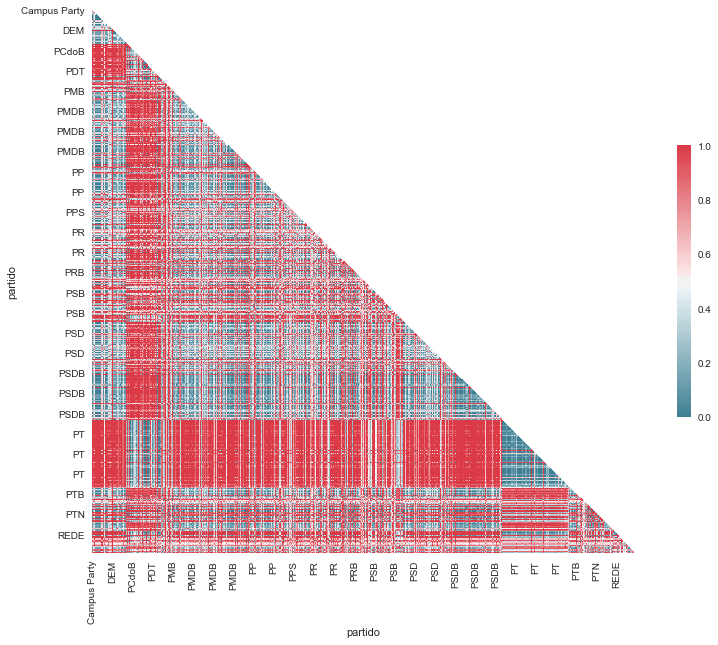

In [12]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


def plot_distances(distances, labels, ticklabels=True):
    
    sns.set(style="white")

    # Generate a large random dataset
    rs = np.random.RandomState(33)
    dists_df = pd.DataFrame(data=distances, columns=labels, index=labels)

    # Generate a mask for the upper triangle
    mask = np.zeros_like(dists_df, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(15, 10))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(dists_df, mask=mask, cmap=cmap, #vmax=.3,
                square=True, xticklabels=ticklabels, yticklabels=ticklabels,
                cbar_kws={"shrink": .5}, ax=ax)

votos.sort_values(['partido', 'uf'], inplace=True)
dists = pairwise_distances(votos[features].values)
plot_distances(dists, votos.partido, ticklabels=20)

### Cenário político: Brasil x EUA

![Brasil x EUA](images/politics-matrix-comp.png)

### Agregando votos por partido

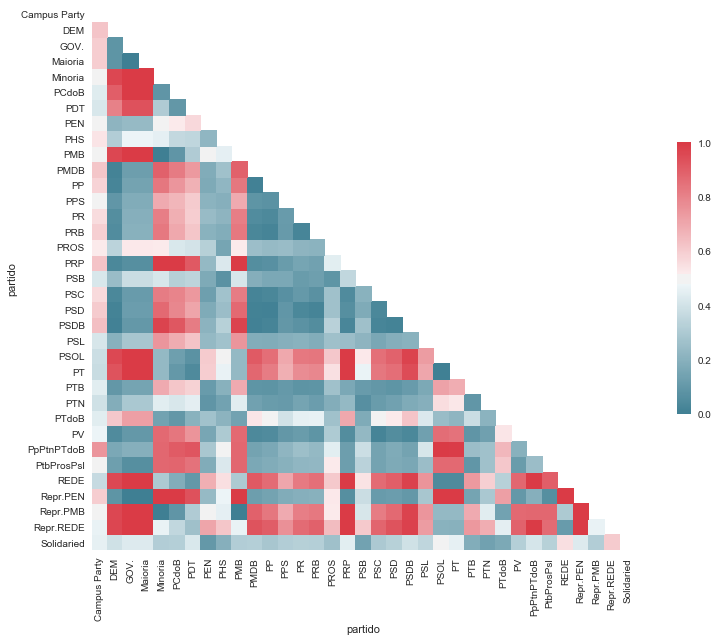

In [13]:
votos_partido = votos.groupby('partido').mean()
dists = pairwise_distances(votos_partido.values, metric='cosine')
plot_distances(dists, votos_partido.index)

### Principal Component Analysis ([PCA](https://en.wikipedia.org/wiki/Principal_component_analysis))

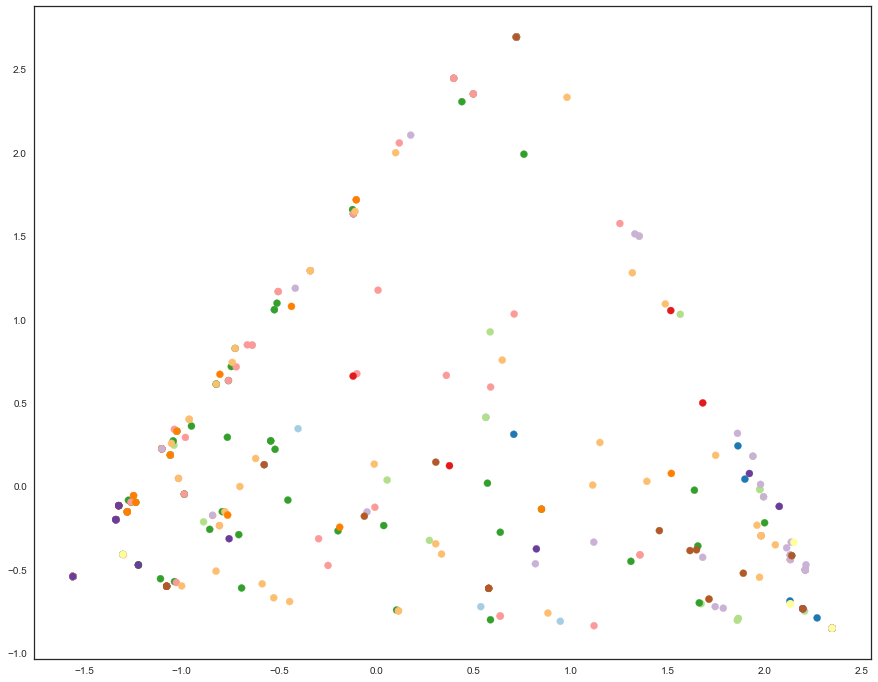

In [15]:
from sklearn.decomposition import PCA
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
labels = le.fit_transform(votos['partido'])

X_pca = PCA(n_components=2).fit_transform(votos[features])

plt.figure(figsize=(15, 12))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, s=50, cmap=plt.cm.Paired)

### t-Distributed Stochastic Neighbor Embedding (t-SNE)

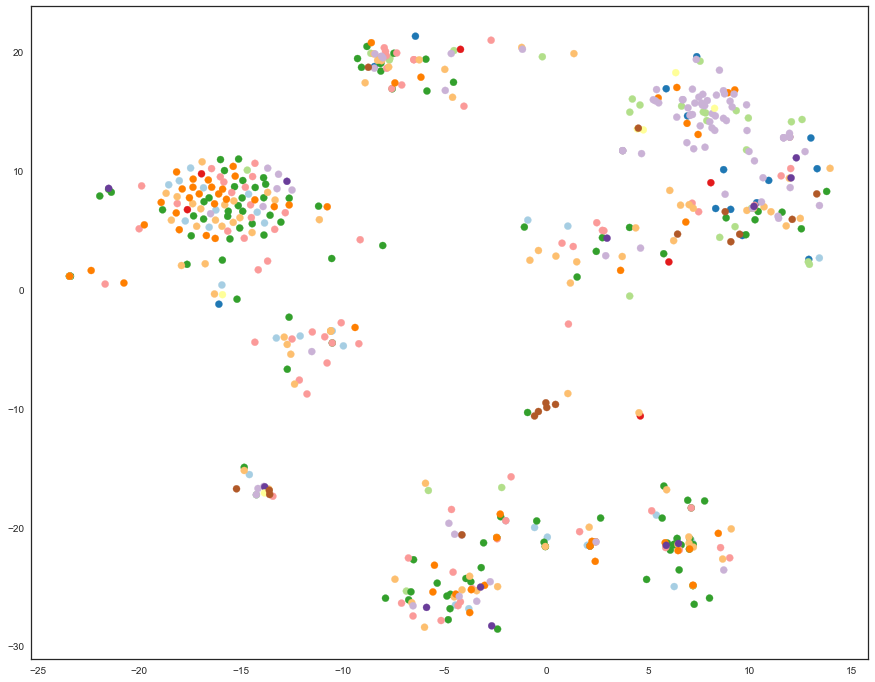

In [17]:
from sklearn.manifold import TSNE
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
labels = le.fit_transform(votos['partido'])

features = votos.columns.drop(['uf', 'nome', 'partido']).tolist()
X_tsne = TSNE(random_state=17, n_iter=2000, perplexity=50).fit_transform(votos[features])

plt.figure(figsize=(15, 12))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, s=50, cmap=plt.cm.Paired)

### Ferramenta: Embedding Projector
Gerando arquivos para visualização no [Embedding Projector](http://projector.tensorflow.org).

In [18]:
pd.DataFrame(votos[features]).to_csv('data/votos.tsv', sep='\t', index=False, header=False)
pd.DataFrame(votos[['nome', 'partido', 'uf']]).to_csv('data/votos_meta.tsv', sep='\t', index=False, encoding='utf-8')

## Clusterização: medindo a coesão partidária

In [33]:
from sklearn.cluster import KMeans

#somente_partidos = [~votos.nome.str.startswith('Bancada')]
kmeans_model = KMeans(n_clusters=5, random_state=1).fit(votos[features])

labels = kmeans_model.labels_

clusters = pd.crosstab(votos["partido"], labels)
# removendo partidos com apenas 1 representante
clusters = clusters[clusters.sum(axis=1) > 1]
print(clusters.shape)
clusters

(24, 5)


col_0,0,1,2,3,4
partido,,,,,
DEM,20,0,3,6,2
PCdoB,0,4,2,0,7
PDT,1,14,6,0,0
PEN,1,0,0,1,1
PHS,1,0,1,2,4
PMDB,35,0,7,18,5
PP,26,0,6,9,6
PPS,5,0,0,3,2
PR,17,0,11,7,5


### Coesão = percentual de votantes concentrados no cluster mais significativo

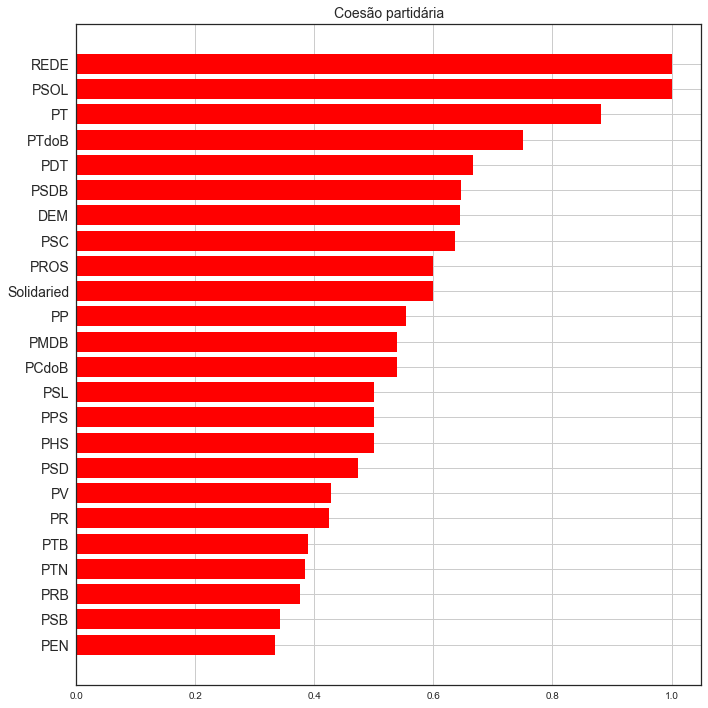

In [34]:
def coesao(clusters):
    return np.max(clusters)/np.sum(clusters)

coesao_partidos = clusters.apply(lambda x: coesao(x), axis=1).sort_values(ascending=True)

# plot coesao
fig = plt.figure(figsize=(10,10))
plt.title("Coesão partidária", fontsize=14)
y_range = [i for i in range(len(coesao_partidos))]
plt.barh(y_range, coesao_partidos,
         color="r", align="center")
plt.yticks(y_range,
           coesao_partidos.index, fontsize=14)
plt.grid()
plt.tight_layout()

## Próximos passos / desafios
* Implementar um sistema de recomendação de parlamentares com base no "vetor político"
* Seria possível justificar estatísticamente uma diminuição no número de partidos?
* Detectar anomalias no posicionamento político
* Correlacionar votações com variáveis macroeconômicas (câmbio, taxa de juros, etc)

![transforma](images/def-transforma.png)